In [1]:
from pyspark.sql import SparkSession

spark= SparkSession.builder.appName("trip_count_sql").getOrCreate()
directory = "/home/ubuntu/working/spark-examples/data"
trip_files = "/trips/*" # 에스터리스크를 활용하여 trips 디렉토리 내의 모든 파일을 불러오기

trip_df = spark.read.csv(f"file://{directory}/{trip_files}",inferSchema=True, header=True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/14 01:01:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
trip_df.createOrReplaceTempView("trips")

### 달라진 점
- 첫 번째 모델은 너무 데이터의 종류가 적어서 예측 성능이 좋지 못했기 때문에 데이터의 종류를 늘릴 예정

In [5]:
query = """
SELECT 
    passenger_count,
    PULocationID as pickup_location_id,
    DOLocationID as dropoff_location_id,
    trip_distance,
    HOUR(tpep_pickup_datetime) as pickup_time,
    DATE_FORMAT(TO_DATE(tpep_pickup_datetime), 'EEEE') AS day_of_week,
    total_amount
FROM
    trips
WHERE
    total_amount < 5000
    AND total_amount > 0
    AND trip_distance > 0
    AND trip_distance < 500
    AND passenger_count < 5
    AND TO_DATE(tpep_pickup_datetime) >= '2021-01-01'
    AND TO_DATE(tpep_pickup_datetime) < '2021-08-01'
"""
data_df = spark.sql(query)
data_df.createOrReplaceTempView("data")

In [6]:
data_df.show()

+---------------+------------------+-------------------+-------------+-----------+-----------+------------+
|passenger_count|pickup_location_id|dropoff_location_id|trip_distance|pickup_time|day_of_week|total_amount|
+---------------+------------------+-------------------+-------------+-----------+-----------+------------+
|              0|               138|                265|         16.5|          0|     Monday|       70.07|
|              1|                68|                264|         1.13|          0|     Monday|       11.16|
|              1|               239|                262|         2.68|          0|     Monday|       18.59|
|              1|               186|                 91|         12.4|          0|     Monday|        43.8|
|              2|               132|                265|          9.7|          0|     Monday|        32.3|
|              1|               138|                141|          9.3|          0|     Monday|       43.67|
|              1|           

In [7]:
# 카테고리 데이터는 원핫인코딩이 필요하다는 것을 인식해야한다!
# 스탠다드 스케일링 하자!

In [2]:
train_df, test_df = data_df.randomSplit([0.8,0.2],seed = 42)

NameError: name 'data_df' is not defined

#### 지금처럼 데이터의 양이 너무나 많고, 그 데이터에 대한 전처리를 수행했음. 그래서 시간이 굉장히 많이 걸렸다고 가정
- 사용할 데이터 마트의 구축이 완료된 상황이라고 가정
- 추후에 다시 이 데이터를 다시 활용한다면 다시 처음부터 전처리하는데 시간이 많이 걸린다.
- 이렇게 전처리가 된 데이터릂 파일이나 데이터베이스에 저장해놓고, 나중에 다시 불러오는게 훨씬 시간적으로 이득

In [3]:
# 파케이(parquet) 형식으로 데이터 마트를 저장
# 하둡에서 사용되는 방식, 열 기반 압축 방식

data_dir = "/home/ubuntu/working/spark-examples/data/ml-data"
hdfs_dir = "~"

# Spark Dataframe의 write를 이용해 데이터를 파일 또는 데이터베이스에 저장이 가능
train_df.write.format("parquet").save(f"{data_dir}/train/")
test_df.write.format("parquet").save(f"{data_dir}/test/")

NameError: name 'train_df' is not defined

## Data 저장 방식
- 전통적인 방식 : 행 기반 압축. schema가 미리 지정되어있음. 
- parquet : 열 기반 압축. 직렬화가 가능. 분산저장과 압축
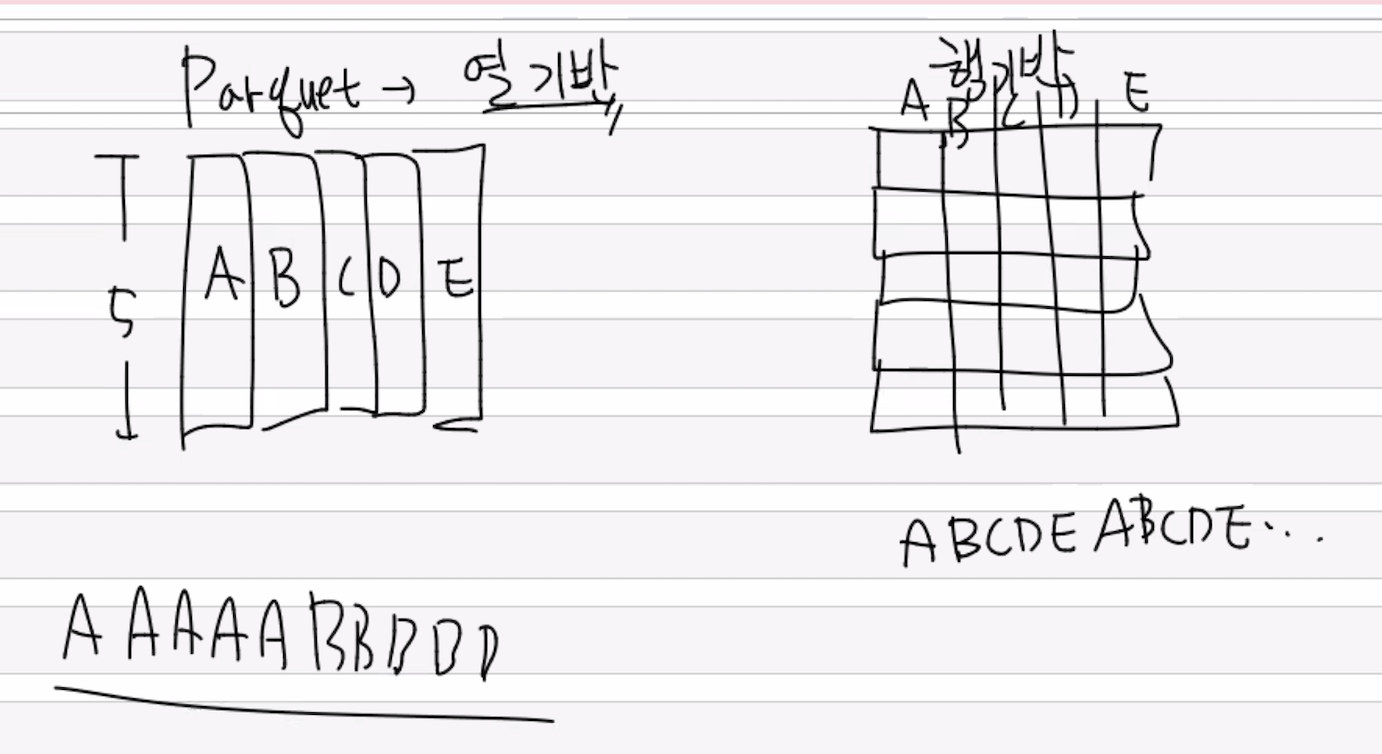

In [4]:
# 분산 저장 되어서 파티션으로 분리된 파일을 불러오기
# from pyspark.sql import SparkSession

# spark= SparkSession.builder.appName("trip_count_sql").getOrCreate()
# data_dir = "/home/ubuntu/working/spark-examples/data/ml-data"

train_df = spark.read.parquet(f"{data_dir}/train/")
test_df = spark.read.parquet(f"{data_dir}/test/") 
# 에스터리스크는 하나씩 하나씩 여러개의 파일을 불러오는 것이고 이것은 분산된 하나의 파일을 불러오는 것!

In [11]:
train_df.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- total_amount: double (nullable = true)



# 파이프라인 구성

In [7]:
# pipeline에 넣을 과정(stage)을 하나씩 넣어 놓을 리스트
stages = []

## 1. OneHotEncoding Stage
- `pickup_location_id`
- `dropoff_location_id`
- `day_of_week`

`pickup_location_id`, `dropoff_location_id`는 숫자 형식의 데이터!
- 숫자 형태의 데이터는 OneHotEncoding이 안된다.
- 숫자 형식의 카테고리 데이터를 임시로 문자열로 처리하기 위해 `StringIndexer`트랜스포머를 활용

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# OneHotEncoding을 수행할 컬럼을 지정
cat_features = [
    "pickup_location_id",
    "dropoff_location_id",
    "day_of_week"
]

for c in cat_features:
    # 1. 데이터를 문자열 형식으로 바꿔준다. setHandleInvalid : Null값 같은 데이터를 어떻게 처리할건지
    cat_indexer = StringIndexer(inputCol=c, outputCol=c+"_idx").setHandleInvalid("keep")
    
    # 2. One Hot Encoding 수행
    # getOutputCol을 통해 String된 콜럼을 가져온다.
    onehot_encoder = OneHotEncoder(inputCols=[cat_indexer.getOutputCol()], outputCols=[c+"_onehot"])
    
    stages += [cat_indexer, onehot_encoder]
    
stages

[StringIndexer_6e6a2570f014,
 OneHotEncoder_3aee07460d8f,
 StringIndexer_fdd4d07028f4,
 OneHotEncoder_e898c536ed7c,
 StringIndexer_f146250b34cf,
 OneHotEncoder_86db6884625b]

# 2. StandardScaler & VectorAssembler Stage
- `passenger_count`
- `trip_dtstance`
- `pickup_time`

- 스케일링 진행을 위해 2차원 형식이 필요
- 스칼라 -> 배열 -> 스케일링

In [9]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

num_features = [
    "passenger_count",
    "trip_distance",
    "pickup_time"
]

for n in num_features:
    # 각각의 컬럼이 벡터화. 1.5 -> [1.5]
    num_assembler = VectorAssembler(inputCols=[n], outputCol=n + "_vector")
    
    # StandardScaling 수행
    num_scaler = StandardScaler(inputCol=num_assembler.getOutputCol(), outputCol=n+"_scaled")
    
    stages += [num_assembler, num_scaler]
    
stages

[StringIndexer_6e6a2570f014,
 OneHotEncoder_3aee07460d8f,
 StringIndexer_fdd4d07028f4,
 OneHotEncoder_e898c536ed7c,
 StringIndexer_f146250b34cf,
 OneHotEncoder_86db6884625b,
 VectorAssembler_3be9633e5063,
 StandardScaler_536fde42b42f,
 VectorAssembler_fea4161889cf,
 StandardScaler_f83faf14076b,
 VectorAssembler_45084900538a,
 StandardScaler_9389a60d6927]

#### 머신러닝을 위한 Preprocessing된 결과물 벡터를 하나로 합쳐야 훈련 가능한 데이터가 된다. - `VectorAssembler`를 사용해서 합친다.

In [11]:
# Assembler 할 데이터는 ?
# OneHotEncoding이 되어 있거나, Scaled된 데이터를 합쳐줘야한다.

assembler_inputs = [c+"_onehot" for c in cat_features] + [n + "_scaled" for n in num_features]
assembler_inputs

['pickup_location_id_onehot',
 'dropoff_location_id_onehot',
 'day_of_week_onehot',
 'passenger_count_scaled',
 'trip_distance_scaled',
 'pickup_time_scaled']

In [12]:
total_assembler = VectorAssembler(inputCols= assembler_inputs, outputCol= "features")
stages.append(total_assembler)
stages

[StringIndexer_6e6a2570f014,
 OneHotEncoder_3aee07460d8f,
 StringIndexer_fdd4d07028f4,
 OneHotEncoder_e898c536ed7c,
 StringIndexer_f146250b34cf,
 OneHotEncoder_86db6884625b,
 VectorAssembler_3be9633e5063,
 StandardScaler_536fde42b42f,
 VectorAssembler_fea4161889cf,
 StandardScaler_f83faf14076b,
 VectorAssembler_45084900538a,
 StandardScaler_9389a60d6927,
 VectorAssembler_ed3958fa5512]

In [13]:
# 파이프라인 등록
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)
pipeline

Pipeline_a53af072cac5

In [14]:
# fit
fitted_transformer = pipeline.fit(train_df)
fitted_transformer

PipelineModel_8dc81598c61c

 #### transformer 파이프라인을 이용해 train_df 데이터 변환 확인

In [15]:
vec_train_df = fitted_transformer.transform(train_df)
vec_train_df.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_location_id_idx: double (nullable = false)
 |-- pickup_location_id_onehot: vector (nullable = true)
 |-- dropoff_location_id_idx: double (nullable = false)
 |-- dropoff_location_id_onehot: vector (nullable = true)
 |-- day_of_week_idx: double (nullable = false)
 |-- day_of_week_onehot: vector (nullable = true)
 |-- passenger_count_vector: vector (nullable = true)
 |-- passenger_count_scaled: vector (nullable = true)
 |-- trip_distance_vector: vector (nullable = true)
 |-- trip_distance_scaled: vector (nullable = true)
 |-- pickup_time_vector: vector (nullable = true)
 |-- pickup_time_scaled: vector (nullable = true)
 |-- features: vector (nullable 

In [17]:
vec_train_df.select("features").first()
# 맨 앞의 숫자는 개수를 뜻한다. 별의미 없음

Row(features=SparseVector(534, {62: 1.0, 312: 1.0, 530: 1.0, 532: 0.0261, 533: 0.3906}))

# 모델 생성

In [18]:
from pyspark.ml.regression import LinearRegression

lr= LinearRegression(
    maxIter=50,
    solver='normal',
    labelCol="total_amount",
    featuresCol="features"
)

In [19]:
model =lr.fit(vec_train_df)

23/06/14 02:32:43 WARN Instrumentation: [6a1c1585] regParam is zero, which might cause numerical instability and overfitting.
23/06/14 02:34:08 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/14 02:34:08 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/06/14 02:34:11 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/06/14 02:34:11 WARN Instrumentation: [6a1c1585] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/06/14 02:34:12 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/06/14 02:34:12 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


 # 테스트 데이터 예측

In [20]:
# test_df 변환
vec_test_df = fitted_transformer.transform(test_df)

In [21]:
# vec_test_df로 예측
predictions = model.transform(vec_test_df)
predictions.show()

+---------------+------------------+-------------------+-------------+-----------+-----------+------------+----------------------+-------------------------+-----------------------+--------------------------+---------------+------------------+----------------------+----------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+
|passenger_count|pickup_location_id|dropoff_location_id|trip_distance|pickup_time|day_of_week|total_amount|pickup_location_id_idx|pickup_location_id_onehot|dropoff_location_id_idx|dropoff_location_id_onehot|day_of_week_idx|day_of_week_onehot|passenger_count_vector|passenger_count_scaled|trip_distance_vector|trip_distance_scaled|pickup_time_vector|  pickup_time_scaled|            features|        prediction|
+---------------+------------------+-------------------+-------------+-----------+-----------+------------+----------------------+-------------------------+----------------------

In [22]:
# 예측한 결과를 따로 확인 할 때는 조회만 일어난다. predictions 데이터도 cache() 처리하는 것이 좋음!
predictions.cache()

DataFrame[passenger_count: int, pickup_location_id: int, dropoff_location_id: int, trip_distance: double, pickup_time: int, day_of_week: string, total_amount: double, pickup_location_id_idx: double, pickup_location_id_onehot: vector, dropoff_location_id_idx: double, dropoff_location_id_onehot: vector, day_of_week_idx: double, day_of_week_onehot: vector, passenger_count_vector: vector, passenger_count_scaled: vector, trip_distance_vector: vector, trip_distance_scaled: vector, pickup_time_vector: vector, pickup_time_scaled: vector, features: vector, prediction: double]

In [24]:
predictions.select("trip_distance","day_of_week","prediction").show()

23/06/14 02:38:32 WARN MemoryStore: Not enough space to cache rdd_95_0 in memory! (computed 440.4 MiB so far)
23/06/14 02:38:32 WARN BlockManager: Persisting block rdd_95_0 to disk instead.


+-------------+-----------+------------------+
|trip_distance|day_of_week|        prediction|
+-------------+-----------+------------------+
|          1.0|   Thursday|13.251716595308377|
|          2.2|   Saturday|15.914445362429937|
|          1.0|     Monday|10.278181010473554|
|          5.2|     Friday| 22.23538812288367|
|          1.9|     Monday|11.643369460731456|
|          4.5|   Thursday|28.273347378101008|
|          0.4|   Thursday| 7.408246384979956|
|         15.4|   Thursday| 45.73283006976534|
|         15.6|   Thursday| 68.54619282108459|
|         18.9|   Thursday| 77.10267278956672|
|         13.6|   Saturday|62.643116917470884|
|         15.2|  Wednesday| 68.12184233120922|
|          3.3|     Friday| 19.71758435607552|
|          3.7|     Monday|20.751286369235252|
|          6.3|     Monday|26.952429587498887|
|          5.2|     Monday|23.690706368190263|
|          0.1|     Monday|12.852588937953684|
|          0.5|     Friday|14.104161988728377|
|          2.

23/06/14 02:38:49 WARN MemoryStore: Not enough space to cache rdd_95_0 in memory! (computed 440.4 MiB so far)


In [25]:
model.summary.rootMeanSquaredError

5.89274566627785

In [26]:
model.summary.r2

0.7957936214535244

In [27]:
spark.stop()